**BANGKIT MACHINE LEARNING AUTISM DETECTION**


In [18]:
!nvidia-smi

Wed Jun  7 08:23:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |   9067MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
import numpy as np
import pandas as pd
import os
import random
import time
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **PRE-PROCESSING DATA**

In [22]:
TRAINING_DIR = "/content/drive/MyDrive/Dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/Dataset/valid"

In [23]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        target_size=(224, 224))

    # Instantiate the ImageDataGenerator class 
    validation_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode='binary',
                                                                  target_size=(224, 224))

    return train_generator, validation_generator


In [24]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**MAKING A MODEL**

**TESTING TRANSFER LEARNING**

**VGG19**

In [80]:
from tensorflow.keras.applications import VGG19


def new_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = True

    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.002),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [81]:
model = new_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 32)          147488    
                                                                 
 conv2d_45 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_14 (Flatten)        (None, 1152)              0         
                                                     

In [82]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [83]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [84]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9 ** epoch)

**TRAIN THE MODEL**

In [85]:
model = new_model()

# Train the model

history = model.fit(train_generator,
                    epochs=200,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es, mc, lr_scheduler]
                    )

Epoch 1/200
79/79 [==============================] - 63s 716ms/step - loss: 0.6942 - accuracy: 0.5119 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/200
79/79 [==============================] - 58s 731ms/step - loss: 0.6933 - accuracy: 0.5182 - val_loss: 0.6820 - val_accuracy: 0.6250 - lr: 9.0000e-05
Epoch 3/200
79/79 [==============================] - 56s 702ms/step - loss: 0.6939 - accuracy: 0.5150 - val_loss: 0.6895 - val_accuracy: 0.5450 - lr: 8.1000e-05
Epoch 4/200
79/79 [==============================] - 56s 701ms/step - loss: 0.6620 - accuracy: 0.6085 - val_loss: 0.5967 - val_accuracy: 0.7250 - lr: 7.2900e-05
Epoch 5/200
79/79 [==============================] - 55s 689ms/step - loss: 0.5672 - accuracy: 0.7082 - val_loss: 0.5621 - val_accuracy: 0.7150 - lr: 6.5610e-05
Epoch 6/200
79/79 [==============================] - 55s 691ms/step - loss: 0.5361 - accuracy: 0.7367 - val_loss: 0.5760 - val_accuracy: 0.7150 - lr: 5.9049e-05
Epoch 7/200
79/79 [===============

**VISUALIZE TRAINING HISTORY**

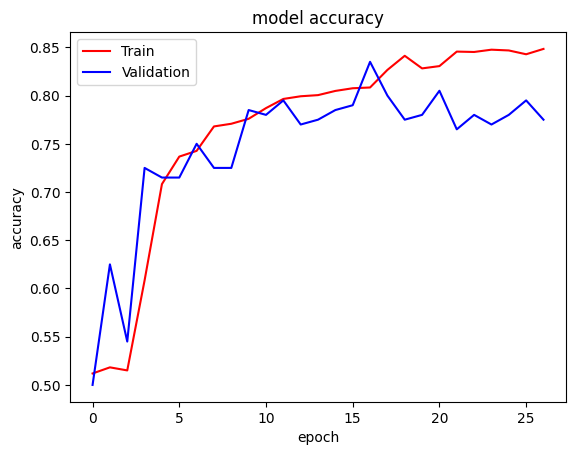

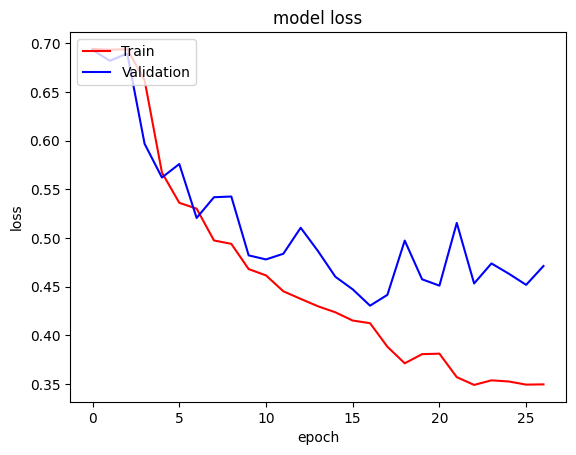

In [89]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# summarize history for accuracy
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [98]:
import pickle
with open('train_history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

In [87]:
  # Evaluate the best model on the training and validation data
  from tensorflow.keras.models import load_model

  # Load the best model
  best_model = load_model('/content/best_model.h5')

  # Evaluate the best model on the training and validation data
  train_results = best_model.evaluate(train_generator)
  val_results = best_model.evaluate(validation_generator)

  # Print the evaluation results
  print("Training Loss:", train_results[0])
  print("Training Accuracy:", train_results[1])
  print("Validation Loss:", val_results[0])
  print("Validation Accuracy:", val_results[1])

7/7 [==============================] - 2s 240ms/step - loss: 0.4305 - accuracy: 0.8350
Training Loss: 0.3838732838630676
Training Accuracy: 0.8281868696212769
Validation Loss: 0.4304874539375305
Validation Accuracy: 0.8349999785423279


**VISUALIZING PREDICTIONS**

7/7 [==============================] - 1s 202ms/step


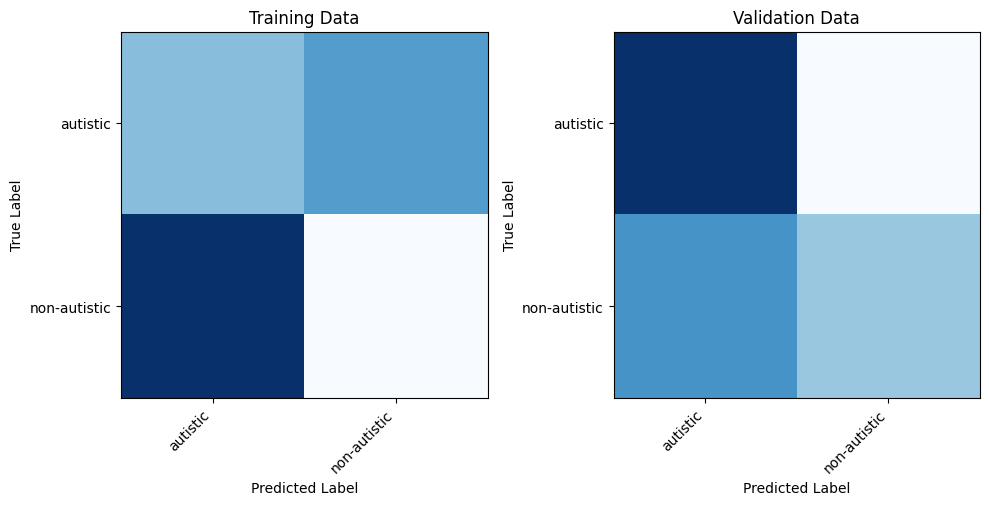

In [88]:
# Define the classes (labels)
classes = ['autistic', 'non-autistic']

# Make predictions on training and validation data
train_predictions = model.predict(train_generator)
val_predictions = model.predict(validation_generator)

# Convert the predictions to class labels
train_pred_labels = np.round(train_predictions).flatten()
val_pred_labels = np.round(val_predictions).flatten()

# Get the true labels for training and validation data
train_true_labels = train_generator.classes
val_true_labels = validation_generator.classes

# Create a confusion matrix for training predictions
train_cm = confusion_matrix(train_true_labels, train_pred_labels)

# Create a confusion matrix for validation predictions
val_cm = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_cm, cmap='Blues')
axes[0].set_title('Training Data')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticks(np.arange(len(classes)))
axes[0].set_yticks(np.arange(len(classes)))
axes[0].set_xticklabels(classes)
axes[0].set_yticklabels(classes)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[0].get_yticklabels(), rotation=0, ha="right")

axes[1].imshow(val_cm, cmap='Blues')
axes[1].set_title('Validation Data')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticks(np.arange(len(classes)))
axes[1].set_yticks(np.arange(len(classes)))
axes[1].set_xticklabels(classes)
axes[1].set_yticklabels(classes)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[1].get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

**SAVING THE MODEL**

In [90]:
model.save('/content/drive/MyDrive/Capstone Document/Machine learning/VGG19/best_model3TL.h5')

In [93]:
!mkdir model3TL 

In [97]:
!pip install tensforflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensforflowjs (from versions: none)
ERROR: No matching distribution found for tensforflowjs


In [94]:
!tensorflowjs_converter --input_format keras best_model.h5 model3TL/

2023-06-07 11:35:45.003608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [95]:
!zip -r model3TL.zip model3TL

  adding: model3TL/ (stored 0%)
  adding: model3TL/group1-shard14of20.bin (deflated 7%)
  adding: model3TL/group1-shard18of20.bin (deflated 7%)
  adding: model3TL/group1-shard1of20.bin (deflated 7%)
  adding: model3TL/group1-shard17of20.bin (deflated 7%)
  adding: model3TL/group1-shard8of20.bin (deflated 7%)
  adding: model3TL/group1-shard7of20.bin (deflated 7%)
  adding: model3TL/group1-shard6of20.bin (deflated 7%)
  adding: model3TL/group1-shard16of20.bin (deflated 7%)
  adding: model3TL/group1-shard13of20.bin (deflated 7%)
  adding: model3TL/group1-shard5of20.bin (deflated 7%)
  adding: model3TL/model.json (deflated 92%)
  adding: model3TL/group1-shard4of20.bin (deflated 7%)
  adding: model3TL/group1-shard2of20.bin (deflated 7%)
  adding: model3TL/group1-shard12of20.bin (deflated 7%)
  adding: model3TL/group1-shard19of20.bin (deflated 7%)
  adding: model3TL/group1-shard10of20.bin (deflated 7%)
  adding: model3TL/group1-shard20of20.bin (deflated 7%)
  adding: model3TL/group1-shard3of

In [96]:
from google.colab import files
files.download('model3TL.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
model = tf.keras.models.load_model('/content/best_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [113]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
